# Fossil Fuel Jobs in CA: Data Exploration

### Author: Rachel Lu

### Description

This project visualizes where fossil fuel jobs are located in relation to communities overburdened by environmental harms.  My data are from the County Business Patterns (CBP)  2018 Survey produced by the United States Census Bureau and the CA County Boundraries dataset from US Census Bureau's 2016 MAF/TIGER database. The former provides countywide employment by fossil fuel industry and the latter provides county geometry data. These data are overlaid on CalEnviroScreen 3.0 data. 

## Importing Libraries
First, we import the modules we'll need to work with and visualize our data. 

In [66]:
# for general data wrangling tasks
import pandas as pd

# to read and visualize spatial data
import geopandas as gpd

# to provide basemaps 
import contextily as ctx

# to give more power to your figures (plots)
import matplotlib.pyplot as plt

We've now given ourselves the ability to work with data generally (pandas module), read and visualize spatial data (geopandas module), provide basemaps (contextily), and produce more robust and interesting plots (matplotlib.pyplot module). 

## Importing & Inspecting Data: FFJOBS

Next, we import our fossil fuel jobs data and give it a label. We're going with the name ffjobs.

In [67]:
ffjobs = gpd.read_file('CBP2018.CB1800CBP_2021-01-23T142924_Extended_Filtered.csv')

Now, let's take a look at the data we've imported. 

In [68]:
ffjobs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GEO_ID           109 non-null    object  
 1   NAME             109 non-null    object  
 2   NAICS2017        109 non-null    object  
 3   NAICS2017_LABEL  109 non-null    object  
 4   NAICS2017_F      109 non-null    object  
 5   LFO              109 non-null    object  
 6   LFO_LABEL        109 non-null    object  
 7   EMPSZES          109 non-null    object  
 8   EMPSZES_LABEL    109 non-null    object  
 9   YEAR             109 non-null    object  
 10  ESTAB            109 non-null    object  
 11  PAYANN           109 non-null    object  
 12  PAYANN_N         109 non-null    object  
 13  PAYQTR1          109 non-null    object  
 14  PAYQTR1_N        109 non-null    object  
 15  EMP              109 non-null    object  
 16  EMP_N            109 non-null    obj

I output a list of all the columns, counts, and associated data types. Usually I skim through this section quickly, but there is a tiny, very significant detail here that causes hours of frustration down the road: our dataset has 0 non-null geometry values! That is not good. Without it, I can't map the data, which is kind of the entire point of this exercise. 

I want to see what the values look like for each column. Overall, I just want a closer look at what's going on with the data. 

In [69]:
ffjobs.shape

(109, 18)

In [70]:
ffjobs.head(5)

,GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,NAICS2017_F,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,geometry
0,0500000US06013,"Contra Costa County, California",2111,Oil and gas extraction,null,1,All establishments,1,All establishments,2018,8,2774,H,397,G,34,J,None
1,0500000US06013,"Contra Costa County, California",2111,Oil and gas extraction,null,1,All establishments,210,Establishments with less than 5 employees,2018,7,N,N,N,N,N,N,None
2,0500000US06013,"Contra Costa County, California",32411,Petroleum refineries,null,1,All establishments,1,All establishments,2018,5,434252,G,116506,G,3357,G,None
3,0500000US06013,"Contra Costa County, California",486,Pipeline transportation,null,1,All establishments,1,All establishments,2018,6,10176,H,2969,H,91,J,None
4,0500000US06013,"Contra Costa County, California",486,Pipeline transportation,null,1,All establishments,241,Establishments with 20 to 49 employees,2018,3,N,N,N,N,N,N,None


I create a dataframe that outputs the first five rows of the dataset. Scrolling all the way over to the right, I confirm that there are no values in the geometry column. Next up: a lot of troubleshooting. 

## Importing & Inspecting Data: CA Counties

I know that our ffjobs dataset contains employment data at the county level, which means that I'll need to add county geometry data to our dataset. I seek out another dataset that has geometry data for CA county boundaries and quickly find a CA County Boundaries shapefil via the CA Open Data Portal. Bless the CA Open Data Portal.

Our next step is to upload this dataset into Jupyterhub. I creatively name it counties. 


In [71]:
counties = gpd.read_file('CA_Counties_TIGER2016.shp')

This uploads the counties dataset. Now I can use this dataset for the basemap in addition to replacing the missing data from ffjobs. 

Okay, next, let's explore the counties dataset and learn more about the data we're working with. 

In [72]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   58 non-null     object  
 1   COUNTYFP  58 non-null     object  
 2   COUNTYNS  58 non-null     object  
 3   GEOID     58 non-null     object  
 4   NAME      58 non-null     object  
 5   NAMELSAD  58 non-null     object  
 6   LSAD      58 non-null     object  
 7   CLASSFP   58 non-null     object  
 8   MTFCC     58 non-null     object  
 9   CSAFP     32 non-null     object  
 10  CBSAFP    45 non-null     object  
 11  METDIVFP  7 non-null      object  
 12  FUNCSTAT  58 non-null     object  
 13  ALAND     58 non-null     int64   
 14  AWATER    58 non-null     int64   
 15  INTPTLAT  58 non-null     object  
 16  INTPTLON  58 non-null     object  
 17  geometry  58 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 8.3+ KB


This produces a table that tells us the column names, non-null counts, and data types we're working with. And this time we have geometry data! Progress. 

After the hours wasted trying to plot the ffjobs dataset without geometry data, I'm extra careful and want to make sure the counties dataset plots well. So, let's double check early on by using the plot function.

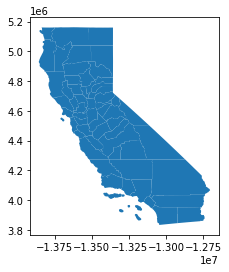

In [73]:
counties.plot()

We produce plot of all the counties in California. It's working as expected. The map is a terrible shade of blue, which we'll fix later. 

Next, I want to take a deeper look at the data contained within the counties dataset. 

In [74]:
counties.head(10)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."
5,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,10510651024,1794730436,+34.1963983,-118.2618616,"MULTIPOLYGON (((-13210018.388 3958856.141, -13..."
6,06,097,01657246,06097,Sonoma,Sonoma County,06,H1,G4020,488,42220,None,A,4081437574,497508807,+38.5251824,-122.9261095,"POLYGON ((-13685069.767 4623872.832, -13685073..."
7,06,031,00277280,06031,Kings,Kings County,06,H1,G4020,546,25260,None,A,3598583450,5468555,+36.0724780,-119.8155301,"POLYGON ((-13353767.857 4335831.239, -13353767..."
8,06,073,00277301,06073,San Diego,San Diego County,06,H1,G4020,None,41740,None,A,10895149811,826195031,+33.0236041,-116.7761174,"POLYGON ((-13073075.796 3919158.524, -13074423..."
9,06,061,00277295,06061,Placer,Placer County,06,H1,G4020,472,40900,None,A,3644333049,246486852,+39.0620323,-120.7227181,"POLYGON ((-13476944.153 4722608.150, -13476936..."


In [75]:
print(counties.crs)

epsg:3857


I output a dataframe the includes the first 10 rows of the dataset. Note that there's both polygon and multipolygon data in the geometry field. I'm happy to see a GEOID but am confused as to why it doesn't match up with the GEO_ID field from the ffjobs dataset. More complications!

## Figuring Out How to Match the Data 

Because the jobs dataset does not contain values for the geometry field, I have to splice geometry data from the counties dataset into the corresponding county row in the ffjobs dataset. We'll need a way to identify the right counties to splice the geometry data into. The counties dataset and ffjobs dataset have ID fields that could be matched: GEO_ID (ffjobs) with GEOID (counties). Let's start the process to figure out how we can match the counties in the ffjobs dataset with their corresponding geometry data from the counties dataset. 


First, I want to compare the GEO_ID field to the GEOID field. I want to find out which counties exist in the ffjobs dataset in order to compare the values in GEO_ID with GEOID. 

In [76]:
ffjobs['NAME'].value_counts()

Los Angeles County, California        22
Kern County, California               14
San Diego County, California          13
Orange County, California             10
San Bernardino County, California      8
Contra Costa County, California        7
Santa Barbara County, California       7
Riverside County, California           5
Sacramento County, California          5
Ventura County, California             4
Fresno County, California              3
Santa Clara County, California         2
San Joaquin County, California         2
Sutter County, California              2
Monterey County, California            1
Alameda County, California             1
Solano County, California              1
Tulare County, California              1
San Luis Obispo County, California     1
Name: NAME, dtype: int64

I produce a list of all the unique county names in the ffjobs dataset, plus the number of times that value occurs. 

I remember that Los Angeles County appears in the first 10 rows of the counties dataframe produced above. So, I choose to check out what the ffjobs GEO_ID data looks like for Los Angeles County in order to compare it to the values in the GEOID counties data. 

In [77]:
ffjobs[ffjobs.NAME == 'Los Angeles County, California']

,GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,NAICS2017_F,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,geometry
19,0500000US06037,"Los Angeles County, California",2111,Oil and gas extraction,null,1,All establishments,1,All establishments,2018,39,235735,J,65894,J,1446,J,None
20,0500000US06037,"Los Angeles County, California",2111,Oil and gas extraction,null,1,All establishments,210,Establishments with less than 5 employees,2018,20,N,N,N,N,N,N,None
21,0500000US06037,"Los Angeles County, California",2111,Oil and gas extraction,null,1,All establishments,220,Establishments with 5 to 9 employees,2018,9,N,N,N,N,N,N,None
22,0500000US06037,"Los Angeles County, California",2111,Oil and gas extraction,null,1,All establishments,230,Establishments with 10 to 19 employees,2018,3,N,N,N,N,N,N,None
23,0500000US06037,"Los Angeles County, California",2111,Oil and gas extraction,null,1,All establishments,242,Establishments with 50 to 99 employees,2018,4,N,N,N,N,N,N,None
24,0500000US06037,"Los Angeles County, California",2212,Natural gas distribution,null,1,All establishments,1,All establishments,2018,61,507130,J,177315,J,5074,J,None
25,0500000US06037,"Los Angeles County, California",2212,Natural gas distribution,null,1,All establishments,210,Establishments with less than 5 employees,2018,21,N,N,N,N,N,N,None
26,0500000US06037,"Los Angeles County, California",2212,Natural gas distribution,null,1,All establishments,230,Establishments with 10 to 19 employees,2018,4,N,N,N,N,N,N,None
27,0500000US06037,"Los Angeles County, California",2212,Natural gas distribution,null,1,All establishments,241,Establishments with 20 to 49 employees,2018,5,N,N,N,N,N,N,None
28,0500000US06037,"Los Angeles County, California",2212,Natural gas distribution,null,1,All establishments,242,Establishments with 50 to 99 employees,2018,18,N,N,N,N,N,N,None


I produce a dataframe that includes all the rows where NAME = Los Angeles County, CA. I notice that the last 5 digits of GEO_ID (ffjobs) for Los Angeles County correspond to the GEOID (counties) values for Los Angeles County. Maybe we can use this to add the geometry data from the counties dataset to the right counties in ffjobs dataset. 

## Cleaning and Trimming the Data (Assignment 4 Update)


Now it's time to clean and trim the data. There are a lot of columns that we don't need, and a few "N" values, meaning not applicable, in the EMP column. We also want to rename columns so that they're more intuitive. 

In [78]:
desired_columns = ['GEO_ID','NAME','NAICS2017_LABEL','EMP','geometry']
ffjobs[desired_columns]

,GEO_ID,NAME,NAICS2017_LABEL,EMP,geometry
0,0500000US06013,"Contra Costa County, California",Oil and gas extraction,34,None
1,0500000US06013,"Contra Costa County, California",Oil and gas extraction,N,None
2,0500000US06013,"Contra Costa County, California",Petroleum refineries,3357,None
3,0500000US06013,"Contra Costa County, California",Pipeline transportation,91,None
4,0500000US06013,"Contra Costa County, California",Pipeline transportation,N,None
...,...,...,...,...,...
104,0500000US06073,"San Diego County, California",Fossil fuel electric power generation,N,None
105,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,70,None
106,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,N,None
107,0500000US06101,"Sutter County, California",Fossil fuel electric power generation,13,None


Now let's redefine our dataframe with just our desired columns. 


In [79]:
ffjobs_trimmed = ffjobs[desired_columns].copy()
ffjobs_trimmed

,GEO_ID,NAME,NAICS2017_LABEL,EMP,geometry
0,0500000US06013,"Contra Costa County, California",Oil and gas extraction,34,None
1,0500000US06013,"Contra Costa County, California",Oil and gas extraction,N,None
2,0500000US06013,"Contra Costa County, California",Petroleum refineries,3357,None
3,0500000US06013,"Contra Costa County, California",Pipeline transportation,91,None
4,0500000US06013,"Contra Costa County, California",Pipeline transportation,N,None
...,...,...,...,...,...
104,0500000US06073,"San Diego County, California",Fossil fuel electric power generation,N,None
105,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,70,None
106,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,N,None
107,0500000US06101,"Sutter County, California",Fossil fuel electric power generation,13,None


Yep, it's redefined! 

Now I want to rename the columns so they're more intuitive. First, I generate a list of current columns. 

In [80]:
list(ffjobs_trimmed)

['GEO_ID', 'NAME', 'NAICS2017_LABEL', 'EMP', 'geometry']

Then I copy and paste the output list above and define the columns with it. Then I replace the values with desired column names

In [81]:
ffjobs_trimmed.columns = ['GEO_ID', 'NAME', 'JOBTYPE', 'EMP', 'geometry']

Let's double check to see that they were properly renamed. 

In [82]:
ffjobs_trimmed


,GEO_ID,NAME,JOBTYPE,EMP,geometry
0,0500000US06013,"Contra Costa County, California",Oil and gas extraction,34,None
1,0500000US06013,"Contra Costa County, California",Oil and gas extraction,N,None
2,0500000US06013,"Contra Costa County, California",Petroleum refineries,3357,None
3,0500000US06013,"Contra Costa County, California",Pipeline transportation,91,None
4,0500000US06013,"Contra Costa County, California",Pipeline transportation,N,None
...,...,...,...,...,...
104,0500000US06073,"San Diego County, California",Fossil fuel electric power generation,N,None
105,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,70,None
106,0500000US06085,"Santa Clara County, California",Fossil fuel electric power generation,N,None
107,0500000US06101,"Sutter County, California",Fossil fuel electric power generation,13,None


Now let's drop all rows with N for employment. 

In [83]:
ffjobs_trimmed2 = ffjobs_trimmed[ffjobs_trimmed.EMP != 'N']
ffjobs_trimmed2
                                

,GEO_ID,NAME,JOBTYPE,EMP,geometry
0,0500000US06013,"Contra Costa County, California",Oil and gas extraction,34,None
2,0500000US06013,"Contra Costa County, California",Petroleum refineries,3357,None
3,0500000US06013,"Contra Costa County, California",Pipeline transportation,91,None
5,0500000US06019,"Fresno County, California",Pipeline transportation,34,None
6,0500000US06029,"Kern County, California",Oil and gas extraction,2246,None
13,0500000US06029,"Kern County, California",Natural gas distribution,106,None
14,0500000US06029,"Kern County, California",Petroleum refineries,295,None
15,0500000US06029,"Kern County, California",Pipeline transportation,392,None
19,0500000US06037,"Los Angeles County, California",Oil and gas extraction,1446,None
24,0500000US06037,"Los Angeles County, California",Natural gas distribution,5074,None


We've now created a new dataframe that removed all rows where employment = N. 

Now, let's make sure employment is in integers. 

In [84]:
print(ffjobs_trimmed2.dtypes)

GEO_ID        object
NAME          object
JOBTYPE       object
EMP           object
geometry    geometry
dtype: object


We see that EMP is an object. We'll convert it to integers so we can better use it in our mapping phase. 


In [85]:
ffjobs_trimmed2.EMP = ffjobs_trimmed2.EMP.astype(int)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


It looks like we've successfully converted. We want to ensure that we modify the base variable directly instead of creating a copy, so we set copy = False. 

Next, let's double check to make sure it worked. 

In [86]:
print(ffjobs_trimmed2.dtypes)

GEO_ID        object
NAME          object
JOBTYPE       object
EMP            int64
geometry    geometry
dtype: object


## Setting geometry in ffjobs equal to geometry from counties dataset 

I want to set the geometry values in ffjobs equal to the corresponding geometry values from the counties dataset. However, I first need to be able to match the fields correctly. We can see that the values in the GEOID column from the counties dataset correspond to the last five digits of the GEO_ID column from the ffjobs dataset. 

First, I have to isolate the last 5 digits of the GEO_ID field. Then, I have to match it with the corresponding GEOID in the county dataset. Finally, I set the geometry field in the ffjobs dataset equal to the corresponding geometry data in the county dataset. 

I create a for loop that helps me do the above for each row in the ffjobs dataset. 

In [87]:

# create a for loop to iterate through each row and run the following code. 
for index, row in ffjobs_trimmed2.iterrows():
    
    # create a new variable 'geomid' to store the value of GEO_ID for a row 
    geomid = row['GEO_ID']
    
    # isolate the last 5 digits of the GEO_ID column from the ffjobs dataset. 
    last_digits = geomid[-5:]
    
    # create a new variable 'countyrow' that finds the collection of rows in county dataset where 
    # GEOID is equal to the last 5 digits in the ffjobs dataset. In other words, we are creating a 
    # dataframe containing the single row in the counties dataset that corresponds to last_digits 
    countyrow = counties[counties.GEOID == last_digits]

    # Set the geometry field in this ffjobs row equal to the geometry data we pulled from the counties dataframe. 
    # Workaround because of a geopandas bug that prevents me from inserting multipolygon data into the geometry column.
    # Issue here: https://github.com/geopandas/geopandas/issues/992
    ffjobs_trimmed2.loc[[index], 'geometry'] = countyrow['geometry'].values

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [88]:
ffjobs_trimmed2

,GEO_ID,NAME,JOBTYPE,EMP,geometry
0,0500000US06013,"Contra Costa County, California",Oil and gas extraction,34,"POLYGON ((-13610773.230 4565908.502, -13610791..."
2,0500000US06013,"Contra Costa County, California",Petroleum refineries,3357,"POLYGON ((-13610773.230 4565908.502, -13610791..."
3,0500000US06013,"Contra Costa County, California",Pipeline transportation,91,"POLYGON ((-13610773.230 4565908.502, -13610791..."
5,0500000US06019,"Fresno County, California",Pipeline transportation,34,"POLYGON ((-13325540.690 4439078.780, -13325502..."
6,0500000US06029,"Kern County, California",Oil and gas extraction,2246,"POLYGON ((-13348728.860 4223737.154, -13349798..."
13,0500000US06029,"Kern County, California",Natural gas distribution,106,"POLYGON ((-13348728.860 4223737.154, -13349798..."
14,0500000US06029,"Kern County, California",Petroleum refineries,295,"POLYGON ((-13348728.860 4223737.154, -13349798..."
15,0500000US06029,"Kern County, California",Pipeline transportation,392,"POLYGON ((-13348728.860 4223737.154, -13349798..."
19,0500000US06037,"Los Angeles County, California",Oil and gas extraction,1446,"MULTIPOLYGON (((-13210018.388 3958856.141, -13..."
24,0500000US06037,"Los Angeles County, California",Natural gas distribution,5074,"MULTIPOLYGON (((-13210018.388 3958856.141, -13..."


This for loop sets the geometry field in the ffjobs row equal to the geometry data we pulled from the counties dataframe. Now, we should have the right geometry data in ffjobs to help us visualize employment data per county. 

## Summing Employment Data

Notice that each county can have multiple rows in our current dataset. This means our maps won't properly map the summed employment per county. We'll need to ensure that each county is unique. Currently, our data is broken out by the Job Type column. We'll need to migrate these data into a single row and create a new summed employement column. 

First, let's determine the unique values in the Job Type column

In [89]:
ffjobs_trimmed2.JOBTYPE.unique()

array(['Oil and gas extraction', 'Petroleum refineries',
       'Pipeline transportation', 'Natural gas distribution',
       'Fossil fuel electric power generation'], dtype=object)

There are 5 unique job types.

Now, let's create dataframe with summed employment. 

In [90]:
#create new geopandas dataframe with just the NAME, geometry, and EMP columns. 
ffjobs_counties = ffjobs_trimmed2[['NAME', 'geometry', 'EMP']]
ffjobs_counties['EMP'] = ffjobs_counties["EMP"].astype(int)

#dissolve rows and sum EMP. 
ffjobs_counties = ffjobs_counties.dissolve(by='NAME', aggfunc='sum')

#check to see what the data looks like. 
ffjobs_counties.head(25)


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,EMP
NAME,,
"Alameda County, California","POLYGON ((-13612246.763 4538150.085, -13612346...",71
"Contra Costa County, California","POLYGON ((-13610773.230 4565908.502, -13610791...",3589
"Fresno County, California","POLYGON ((-13325540.690 4439078.780, -13325502...",56
"Kern County, California","POLYGON ((-13348728.860 4223737.154, -13349798...",3182
"Los Angeles County, California","MULTIPOLYGON (((-13211237.221 3898803.431, -13...",11710
"Monterey County, California","POLYGON ((-13583963.802 4376069.357, -13583986...",37
"Orange County, California","POLYGON ((-13134488.102 3973319.471, -13134662...",1012
"Riverside County, California","POLYGON ((-13099281.751 4011348.117, -13099285...",434
"Sacramento County, California","POLYGON ((-13490651.476 4680831.603, -13490511...",125


I create a new dataframe with unique counties and a summed employment column. I used the dissolve and aggfunc functions to dissolve the rows and sum the EMP into total EMP per county. 

Now, let's add back in the individual JOBTYPE employment counts. 

First, we create empty columns for each unique value in JOBTYPE. We previously already listed all unique values in JOBTYPE. 

In [91]:
#create new variable equal to unique values of JOBTYPE. 
#the ffjobs_trimmed2.JOBTYPE.unique() function returns a list of unique JOBTYPE values in the ffjobs_trimmed2 dataframe
job_types = ffjobs_trimmed2.JOBTYPE.unique()


#create a for loop that creates a new column in ffjobs_counties called jobs that gives it a default value 0 for all rows. 
for job in job_types: 
    ffjobs_counties[job]=0

#let's check the data
ffjobs_counties.head(10)




,geometry,EMP,Oil and gas extraction,Petroleum refineries,Pipeline transportation,Natural gas distribution,Fossil fuel electric power generation
NAME,,,,,,,
"Alameda County, California","POLYGON ((-13612246.763 4538150.085, -13612346...",71,0,0,0,0,0
"Contra Costa County, California","POLYGON ((-13610773.230 4565908.502, -13610791...",3589,0,0,0,0,0
"Fresno County, California","POLYGON ((-13325540.690 4439078.780, -13325502...",56,0,0,0,0,0
"Kern County, California","POLYGON ((-13348728.860 4223737.154, -13349798...",3182,0,0,0,0,0
"Los Angeles County, California","MULTIPOLYGON (((-13211237.221 3898803.431, -13...",11710,0,0,0,0,0
"Monterey County, California","POLYGON ((-13583963.802 4376069.357, -13583986...",37,0,0,0,0,0
"Orange County, California","POLYGON ((-13134488.102 3973319.471, -13134662...",1012,0,0,0,0,0
"Riverside County, California","POLYGON ((-13099281.751 4011348.117, -13099285...",434,0,0,0,0,0
"Sacramento County, California","POLYGON ((-13490651.476 4680831.603, -13490511...",125,0,0,0,0,0


Next, we create a for loop to iterate through each row, adding back the EMP values under each new job type column. Ultimately, we want to transpose data from rows into column values. Unfortunately, we can't use the merge function here because merge is just for transferring data from columns to columns. 

In [92]:
# create a for loop to iterate through each row and run the following code. 
for index, row in ffjobs_counties.iterrows():
    
    #define a new variable that returns a dataframe which includes only 
    # the rows in ffjobs_trimmed2 equal to a particular NAME in the ffjobs_counties dataframe.
    # for example, all the LA county rows in the ffjobs_trimmed2 dataframe where 
    # the county NAME is equal to a particular county NAME value in the ffjobs_counties dataframe. 
    
    countyrows = ffjobs_trimmed2[ffjobs_trimmed2['NAME'] == index]
    
    #now, let's create another loop ( a loop within a loop!)
    # this loop says for a new varaiable trimmed_index, iterate through each row in the countrows datagrame we created above
    for trimmed_index, trimmed_row in countyrows.iterrows():
        # where the value in the ffjobs_counties row is equal to the value of ffjobs_trimmed2 JOBTYPE,
        # we set equal to the employment value for that JOBTYPE in the ffjobs_trimmed2 dataframe. 
        row[trimmed_row.JOBTYPE] = trimmed_row.EMP
        ffjobs_counties.loc[[index], trimmed_row.JOBTYPE] = trimmed_row.EMP

#check the results
ffjobs_counties.head()    
    
    

,geometry,EMP,Oil and gas extraction,Petroleum refineries,Pipeline transportation,Natural gas distribution,Fossil fuel electric power generation
NAME,,,,,,,
"Alameda County, California","POLYGON ((-13612246.763 4538150.085, -13612346...",71,0,0,0,0,71
"Contra Costa County, California","POLYGON ((-13610773.230 4565908.502, -13610791...",3589,34,3357,91,0,107
"Fresno County, California","POLYGON ((-13325540.690 4439078.780, -13325502...",56,0,0,34,0,22
"Kern County, California","POLYGON ((-13348728.860 4223737.154, -13349798...",3182,2246,295,392,106,143
"Los Angeles County, California","MULTIPOLYGON (((-13211237.221 3898803.431, -13...",11710,1446,4425,436,5074,329


Awesome. I can't believe that worked...we might have been able to transpose the data with some kind of pivot table function as well, but I didn't do further research on those options. 

We just created a dataframe with total employment as well as employment numbers for each job type. 

Next, let's check out the entire dataframe.  



In [93]:
ffjobs_counties

,geometry,EMP,Oil and gas extraction,Petroleum refineries,Pipeline transportation,Natural gas distribution,Fossil fuel electric power generation
NAME,,,,,,,
"Alameda County, California","POLYGON ((-13612246.763 4538150.085, -13612346...",71,0,0,0,0,71
"Contra Costa County, California","POLYGON ((-13610773.230 4565908.502, -13610791...",3589,34,3357,91,0,107
"Fresno County, California","POLYGON ((-13325540.690 4439078.780, -13325502...",56,0,0,34,0,22
"Kern County, California","POLYGON ((-13348728.860 4223737.154, -13349798...",3182,2246,295,392,106,143
"Los Angeles County, California","MULTIPOLYGON (((-13211237.221 3898803.431, -13...",11710,1446,4425,436,5074,329
"Monterey County, California","POLYGON ((-13583963.802 4376069.357, -13583986...",37,37,0,0,0,0
"Orange County, California","POLYGON ((-13134488.102 3973319.471, -13134662...",1012,64,0,141,766,41
"Riverside County, California","POLYGON ((-13099281.751 4011348.117, -13099285...",434,0,0,7,427,0
"Sacramento County, California","POLYGON ((-13490651.476 4680831.603, -13490511...",125,0,0,17,34,74


## Mapping the Data

First, let's visualize all fossil fuel employment in California. I want to use the counties dataset as the basemap, and I also want to ensure that counties with no fossil fuel employment don't stand out on the map. 


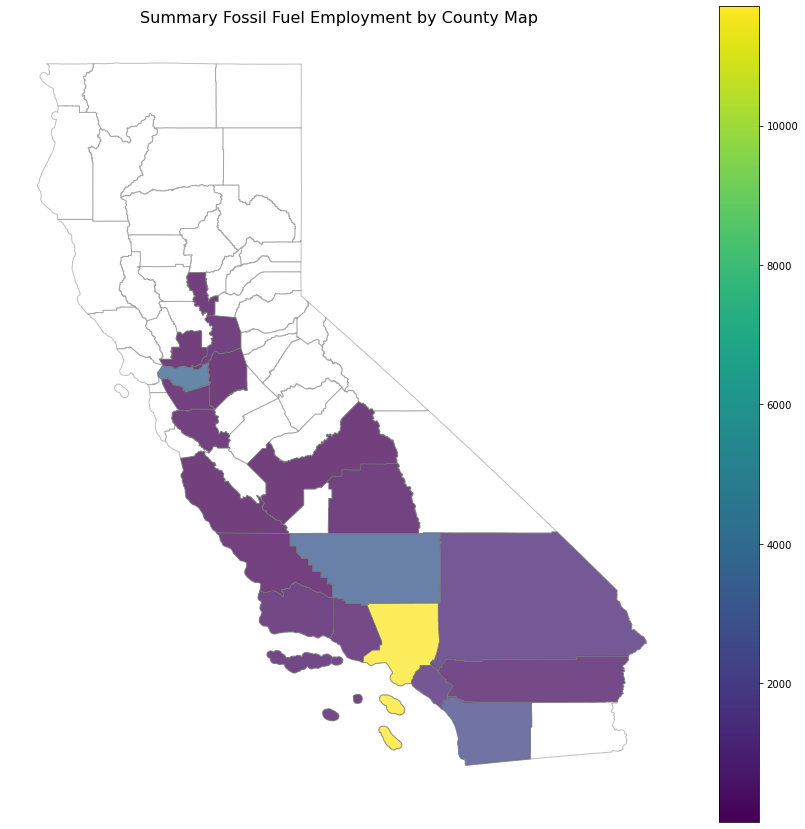

In [94]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Summary Fossil Fuel Employment by County Map ',fontsize=16)

# add a basemap
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax)

# plot employment values for ffjobs
ffjobs_counties.plot(column = 'EMP',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            edgecolor='grey',
            figsize=(12,10),
            ax=ax)



Great, the map above visualizes the employment count in each county. It sets all counties with no fossil fuel generation jobs to white. I also soften the county boundaries by setting them to grey. It would be better if we could normalize the data, but our data set did not include total employment counts per county.

Next, let's visualize some subsets of our data side by side. We use subplots to generate two plots next to each other.  

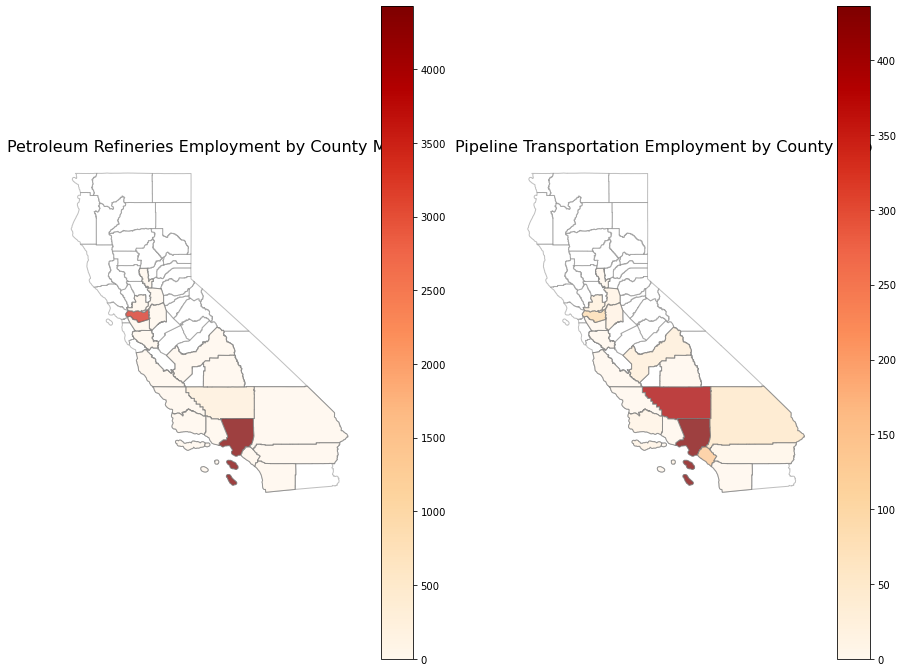

In [95]:
# use subplots that make it easier to create multiple layered maps
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs

# turn the axis off
ax1.axis('off')
ax2.axis('off')

# set a title for ax1
ax1.set_title('Petroleum Refineries Employment by County Map ',fontsize=16)

# add a basemap
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax1)

# define petroleum variable
# petroleum = ffjobs_counties[ffjobs_counties == 'Petroleum refineries']

# plot EMPlOYMENT values for petroleum refineries 
ffjobs_counties.plot(column = 'Petroleum refineries',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            cmap = 'OrRd', 
            edgecolor='grey',
            figsize=(12,10), ax=ax1)


# set a title for ax2
ax2.set_title('Pipeline Transportation Employment by County Map ',fontsize=16)

# add a basemap
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax2)

# define pipeline variable
# pipeline = ffjobs_trimmed2[ffjobs_trimmed2.JOBTYPE_NAICS == 'Pipeline transportation']

# plot EMP values for pipeline transportation
ffjobs_counties.plot(column = 'Pipeline transportation',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            cmap = 'OrRd', 
            edgecolor='grey',
            figsize=(12,10),
            ax=ax2)

Next, I want to visualize only the counties with over 500 fossil fuel jobs. 

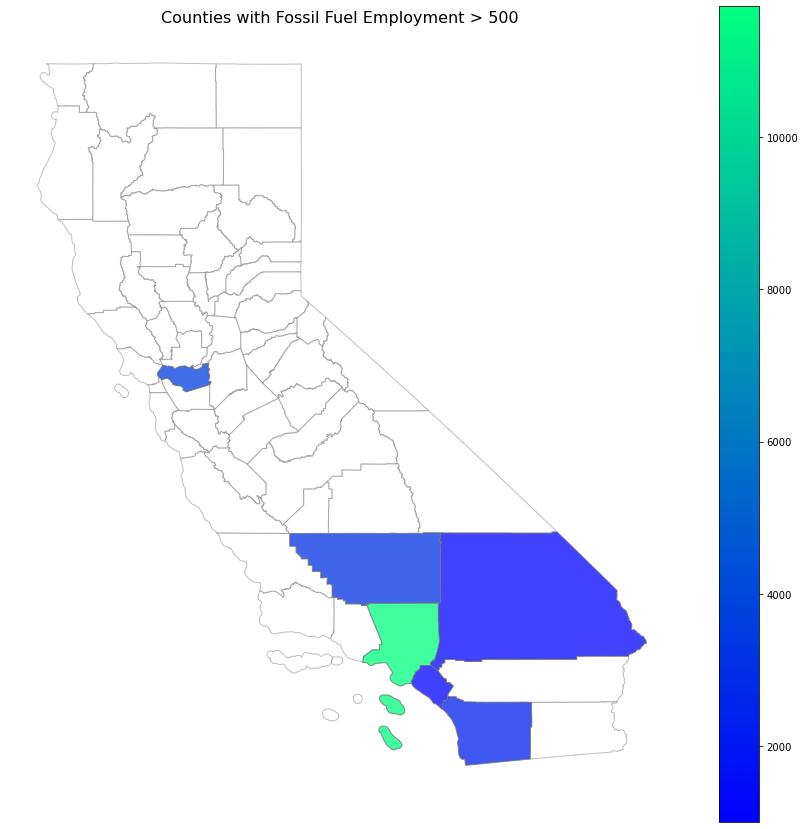

In [96]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Counties with Fossil Fuel Employment > 500 ',fontsize=16)

# add a basemap
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax)

# plot all of the values where EMP is greater than 500 using the noN variable, which excludes all N values. 
ffjobs_counties[ffjobs_counties['EMP'] > 500].plot(column = 'EMP',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            cmap = 'winter', 
            edgecolor='grey',
            figsize=(12,10),  
            ax=ax)


I produce a plot that visualizes all the counties with more than 500 fossil fuel jobs. 

To create the desired plot, I had to deal with two problems that stemmed from comparing EMP with an integer (500): 1) there were a few EMP rows with N values, which are none integer and 2) EMP data was originally string data type. So, on top of what I've done above, I must create a new variable assigned to a new dataframe to exclude all rows that have the value N within the EMP column. I also use the astype function to convert EMP values to integers. 


Next, I want to see which counties are in the top quantiles for fossil fuel employment. 

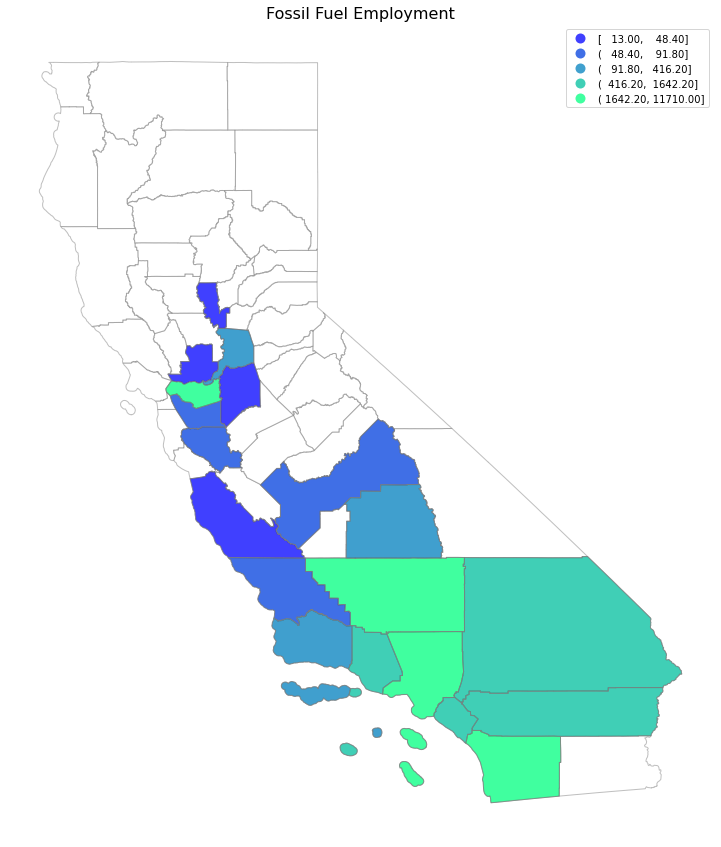

In [97]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Fossil Fuel Employment',fontsize=16)

# add a basemap
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax)

# plot all of the values where EMP is greater than 500 using the noN variable, which excludes all N values. 
ffjobs_counties.plot(column = 'EMP',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            cmap = 'winter', 
            edgecolor='grey',
            figsize=(12,10), 
            scheme = 'Quantiles',                                       
            ax=ax)




# Import CalEnviroScreen

Our research question centers on whether fossil fuel and clean energy jobs are located in disadvantaged communities. Now it's time to overlay the fossil fuel data with CalEnviroScreen data to answer this question. 




In [98]:
gdf = gpd.read_file('../CES3June2018Update.shp')


In [99]:
type(gdf)


geopandas.geodataframe.GeoDataFrame

In [100]:
gdf.head()

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,...,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry
0,6.083002e+09,3930,Santa Barbara,93454,Santa Maria,-120.427059,34.930669,29.51,59,0.035,...,0.5,7.2,1.6,3507,6,12,6999.357622,2.847611e+06,55-60%,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,11406,Santa Barbara,93455,Santa Maria,-120.478083,34.928796,33.17,65,0.035,...,0.2,5.5,1.6,2733,7,14,19100.578003,1.635292e+07,65-70%,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,2084,Santa Barbara,93454,Santa Maria,-120.426777,34.942111,22.85,45,0.035,...,0.5,2.9,2.6,4689,5,9,4970.985933,1.352330e+06,40-45%,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."
3,6.083002e+09,4375,Santa Barbara,93455,Santa Maria,-120.410028,34.871428,4.45,2,0.035,...,0.6,4.0,2.6,7864,1,1,6558.956142,2.417717e+06,1-5% (lowest scores),"POLYGON ((-37341.662 -348530.437, -37252.307 -..."
4,6.083002e+09,3826,Santa Barbara,93455,Santa Maria,-120.427716,34.872288,5.28,3,0.035,...,0.8,3.5,3.2,7863,1,1,6570.368642,2.608422e+06,1-5% (lowest scores),"POLYGON ((-39465.107 -348499.262, -38244.305 -..."


In [101]:
columns_to_keep = ['tract', 'pop2010', 'California', 'ZIP', 'City', 'Longitude', 'Latitude', 'CIscore', 'CIscoreP', 'edu', 'eduP', 'pov', 'povP', 'unemp', 'unempP', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p', 'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct', 'geometry']

In [102]:
# to make sure I got the columns I wanted
columns_to_keep


['tract',
 'pop2010',
 'California',
 'ZIP',
 'City',
 'Longitude',
 'Latitude',
 'CIscore',
 'CIscoreP',
 'edu',
 'eduP',
 'pov',
 'povP',
 'unemp',
 'unempP',
 'Pop_11_64_',
 'Elderly_ov',
 'Hispanic_p',
 'White_pct',
 'African_Am',
 'Native_Ame',
 'Asian_Amer',
 'Other_pct',
 'geometry']

In [103]:
# to redefine the dataframe with only those columns
gdf = gdf[columns_to_keep]


In [104]:
# to check the new dataframe
gdf.head()

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,edu,...,unempP,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,geometry
0,6.083002e+09,3930,Santa Barbara,93454,Santa Maria,-120.427059,34.930669,29.51,59,24.8,...,32,70.5,13.1,57.5,31.3,1.9,0.5,7.2,1.6,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,11406,Santa Barbara,93455,Santa Maria,-120.478083,34.928796,33.17,65,46.0,...,61,73.2,6.2,74.0,17.4,1.4,0.2,5.5,1.6,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,2084,Santa Barbara,93454,Santa Maria,-120.426777,34.942111,22.85,45,26.2,...,7,72.5,13.2,52.2,40.9,0.8,0.5,2.9,2.6,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."
3,6.083002e+09,4375,Santa Barbara,93455,Santa Maria,-120.410028,34.871428,4.45,2,6.1,...,47,74.7,14.4,20.0,71.9,1.0,0.6,4.0,2.6,"POLYGON ((-37341.662 -348530.437, -37252.307 -..."
4,6.083002e+09,3826,Santa Barbara,93455,Santa Maria,-120.427716,34.872288,5.28,3,12.1,...,32,73.6,15.9,25.7,65.4,1.5,0.8,3.5,3.2,"POLYGON ((-39465.107 -348499.262, -38244.305 -..."



## Sorting and mapping CES scores

To continue exploring the data, I'm going to sort it. I want to see which counties have the highest CES score (that is, are most burdened by and vulnerable to environmental pollution). So I'll create a new dataframe.

In [105]:
# to sort the data by CES score
gdf_sortbyCES = gdf.sort_values(by='CIscore', ascending = False)

In [106]:
gdf_sortbyCES.head()


,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,edu,...,unempP,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,geometry
3067,6.019001e+09,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.09,100,53.3,...,92,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8,"POLYGON ((19285.231 -143860.955, 19337.280 -14..."
3630,6.071002e+09,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.68,100,53.3,...,72,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7,"POLYGON ((221111.498 -435769.960, 221843.092 -..."
3084,6.019000e+09,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.97,100,42.3,...,88,72.5,6.0,63.6,5.3,18.9,0.6,9.8,1.8,"POLYGON ((17443.101 -141462.998, 18343.091 -14..."
3379,6.077001e+09,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.49,100,40.8,...,95,74.5,6.8,57.4,6.0,12.5,0.3,20.9,2.8,"POLYGON ((-113987.015 -7108.742, -113831.958 -..."
2916,6.019002e+09,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.03,100,45.1,...,94,72.1,13.1,71.8,21.4,1.2,0.5,4.5,0.6,"POLYGON ((19969.486 -145534.647, 20646.564 -14..."


In [107]:
gdf_sortbyCES[['California','City','CIscore','CIscoreP', 'geometry']]

,California,City,CIscore,CIscoreP,geometry
3067,Fresno,Fresno,94.09,100,"POLYGON ((19285.231 -143860.955, 19337.280 -14..."
3630,San Bernardino,Ontario,90.68,100,"POLYGON ((221111.498 -435769.960, 221843.092 -..."
3084,Fresno,Fresno,85.97,100,"POLYGON ((17443.101 -141462.998, 18343.091 -14..."
3379,San Joaquin,Stockton,82.49,100,"POLYGON ((-113987.015 -7108.742, -113831.958 -..."
2916,Fresno,Fresno,82.03,100,"POLYGON ((19969.486 -145534.647, 20646.564 -14..."
...,...,...,...,...,...
5521,Solano,Travis AFB,0.00,0,"POLYGON ((-165293.742 31212.731, -167315.316 2..."
6485,Los Angeles,Los Angeles,0.00,0,"POLYGON ((156330.169 -427148.499, 156829.129 -..."
6452,Los Angeles,Pomona,0.00,0,"POLYGON ((202617.437 -439728.221, 202248.399 -..."
532,Orange,Anaheim,0.00,0,"POLYGON ((201165.266 -458576.548, 201859.426 -..."


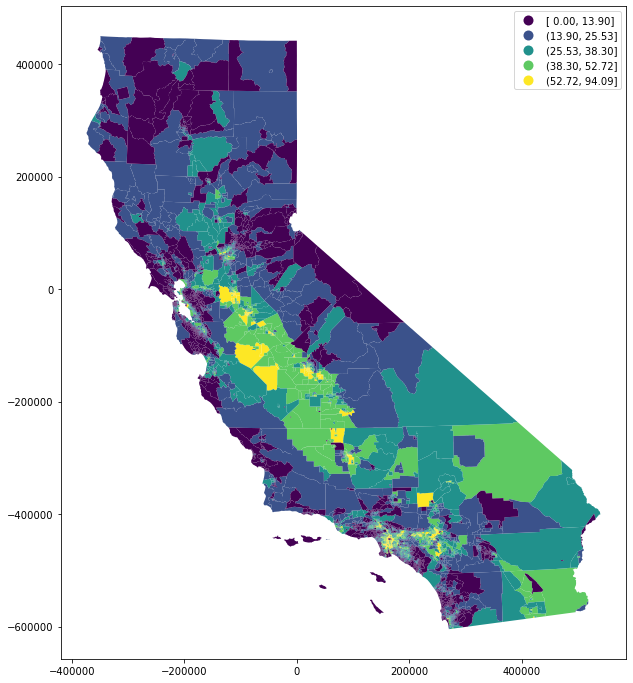

In [108]:

# to map the sorted dataframe using geopanas chloropleth maps
gdf_sortbyCES.plot(figsize=(12,12),
                   column='CIscore',
                   legend=True,
                   scheme='NaturalBreaks')

# Overlay Fossil Fuel Jobs and CalEnviroScreen



First, let's check what CRS our data is in. 


In [109]:
print(gdf.crs)

epsg:3310


In [110]:
print(ffjobs_counties.crs)

None


In [111]:
print(counties.crs)

epsg:3857


Our ffjobs_counties dataframe does not have CRS data, but the original counties dataframe does (where we sourced our ffjobs_counties geometry data). 

In [112]:
#create a new variable that sets ffjobs_counties crs to the counties crs. 
ffjobs_counties = ffjobs_counties.set_crs('epsg:3857')

#convert ffjobs_counties to the same crs as the gdf dataframe. 
ffjobsreproject = ffjobs_counties.to_crs('epsg:3310')


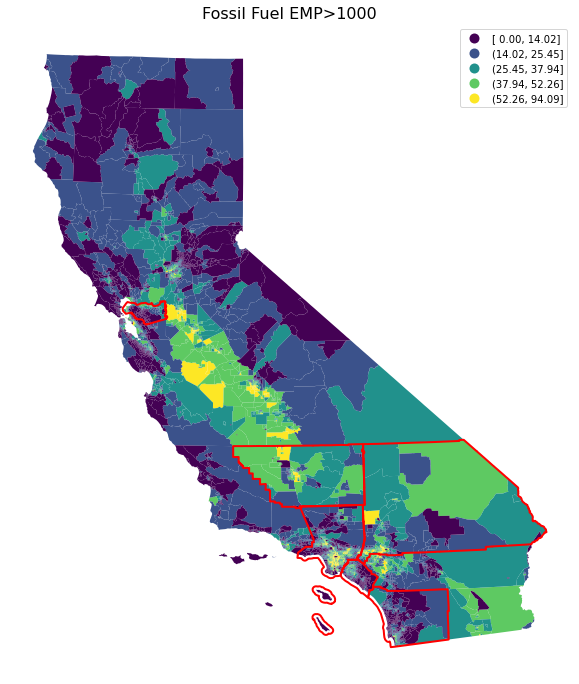

In [113]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(12, 12))

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Fossil Fuel EMP>1000',fontsize=16)

# first layer
gdf_sortbyCES.plot(figsize=(12,12),
                   column='CIscore',
                   legend=True,
                   scheme='NaturalBreaks',
                  ax=ax)

# second layer

ffjobsreproject[ffjobsreproject['EMP'] > 1000].plot(ax=ax,edgecolor='red',color='none',linewidth=2)



